In [2]:
import os
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

load_dotenv()
uri = os.getenv("MongoDbUri")
client = pymongo.MongoClient(uri)

db = client['test']

# Fetch orders data
orders = db['orders'].find()
orders_list = list(orders)
orders_df = pd.DataFrame(orders_list)

# Save orders data to CSV
orders_df.to_csv('orders_data.csv', index=False)

# Fetch restaurant data
restaurants = db['restaurants'].find()
restaurants_list = list(restaurants)
restaurants_df = pd.DataFrame(restaurants_list)

# Save restaurant data to CSV
restaurants_df.to_csv('restaurants_data.csv', index=False)

# Load the CSV files
df_orders = pd.read_csv('orders_data.csv')
df_restaurants = pd.read_csv('restaurants_data.csv')

# Rename columns to match for merging
df_orders.rename(columns={'restaurant': 'restaurant_id'}, inplace=True)
df_restaurants.rename(columns={'_id': 'restaurant_id'}, inplace=True)

# Extract city and restaurant ID from order data
df_orders['city'] = df_orders['deliveryDetails'].apply(lambda x: eval(x)['city'])

# Process order counts
order_counts = df_orders.groupby(['city', 'restaurant_id']).size().reset_index(name='order_count')
order_counts.to_csv('processed_orders_data.csv', index=False)

#print(order_counts)

# Load processed order counts
order_counts = pd.read_csv('processed_orders_data.csv')

# Total orders per city
total_orders_per_city = order_counts.groupby('city')['order_count'].sum().reset_index(name='total_orders')

# Clean city names by stripping leading/trailing spaces and converting to lowercase
total_orders_per_city['city'] = total_orders_per_city['city'].str.strip().str.lower()

# Remove duplicates or inconsistent city names
total_orders_per_city = total_orders_per_city.drop_duplicates().reset_index(drop=True)
total_orders_per_city.to_csv('total_orders_per_city.csv', index=False)

# Merge order counts with restaurant names
merged_data = pd.merge(order_counts, df_restaurants, on='restaurant_id')
# Clean up merged_data columns
merged_data.rename(columns={'city_x': 'order_city', 'city_y': 'restaurant_city'}, inplace=True)

#print(merged_data)
# Extract city information from restaurants
df_restaurants['city'] = df_restaurants['city'].str.strip().str.lower()

# Group restaurants by city
restaurants_by_city = df_restaurants.groupby('city')['restaurantName'].apply(list).reset_index()

# Display cities with their restaurants
#print(restaurants_by_city)


In [3]:
# Extract city information from restaurants
df_restaurants['city'] = df_restaurants['city'].str.strip().str.lower()

# Group restaurants by city
restaurants_by_city = df_restaurants.groupby('city')['restaurantName'].apply(list).reset_index()

# Display cities with their restaurants
print(restaurants_by_city)

         city                                     restaurantName
0      london  [Restaurant 1, Restaurant 2, Restaurant 3, Res...
1  manchester  [Restaurant 1, Restaurant 2, Restaurant 3, Res...


In [4]:
# user to select a city to view its restaurants
selected_city = input("Enter the city you want to view restaurants for: ").strip().lower()

In [5]:
# Filter the restaurants for the selected city
city_restaurants = restaurants_by_city[restaurants_by_city['city'] == selected_city]

In [6]:
if not city_restaurants.empty:
    print(f"Restaurants in {selected_city.capitalize()}:")
    for restaurant in city_restaurants['restaurantName'].values[0]:
        print(f"- {restaurant}")
else:
    print("No restaurants found in this city.")

Restaurants in London:
- Restaurant 1
- Restaurant 2
- Restaurant 3
- Restaurant 4
- Restaurant 5
- Restaurant 6
- Restaurant 7


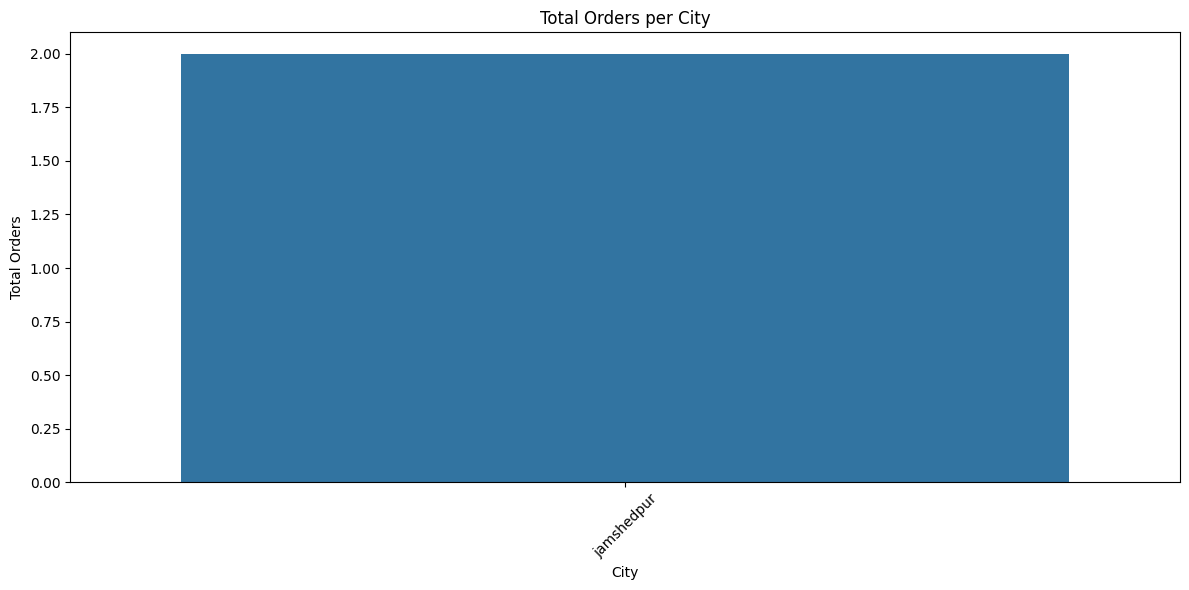

In [7]:
 # Plot total orders per city
if not total_orders_per_city.empty:
    plt.figure(figsize=(12, 6))
    sns.barplot(data=total_orders_per_city, x='city', y='total_orders')
    plt.title('Total Orders per City')
    plt.xlabel('City')
    plt.ylabel('Total Orders')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No orders data available.")

In [8]:
print(merged_data.columns)

Index(['order_city', 'restaurant_id', 'order_count', 'user', 'restaurantName',
       'restaurant_city', 'country', 'deliveryPrice', 'estimatedDeliveryTime',
       'cuisines', 'menuItems', 'imageUrl', 'lastUpdated'],
      dtype='object')


Index(['order_city', 'restaurant_id', 'order_count', 'user', 'restaurantName',
       'restaurant_city', 'country', 'deliveryPrice', 'estimatedDeliveryTime',
       'cuisines', 'menuItems', 'imageUrl', 'lastUpdated'],
      dtype='object')


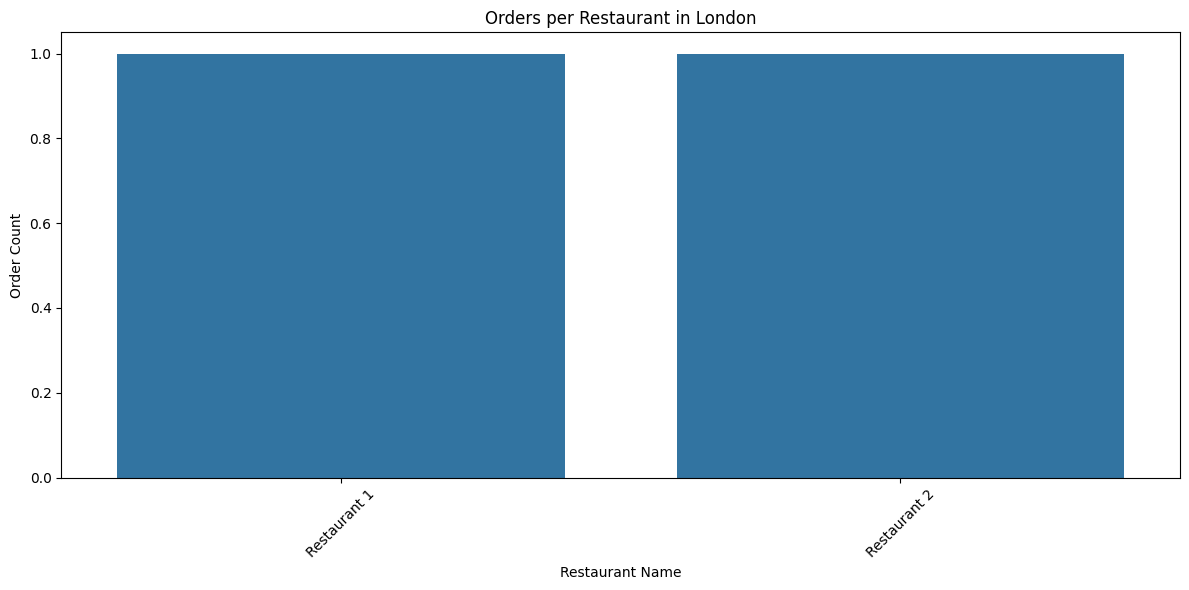

In [9]:

view_restaurant_orders = input("Do you want to see the order counts for each restaurant in this city? (yes/no): ").strip().lower()

if view_restaurant_orders == 'yes':
    # Filter data for the selected city
    city_restaurant_data = merged_data[merged_data['restaurant_city'].str.lower() == selected_city]
    
    # Print column names to verify
    print(city_restaurant_data.columns)
    
    if not city_restaurant_data.empty:
        plt.figure(figsize=(12, 6))
        # Replace 'restaurantName' with the correct column name if necessary
        sns.barplot(data=city_restaurant_data, x='restaurantName', y='order_count')
        plt.title(f'Orders per Restaurant in {selected_city.capitalize()}')
        plt.xlabel('Restaurant Name')
        plt.ylabel('Order Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("No restaurant data available for this city.")
else:
    print("Okay, no restaurant data will be shown.")